....



NameError: name 'show_values' is not defined

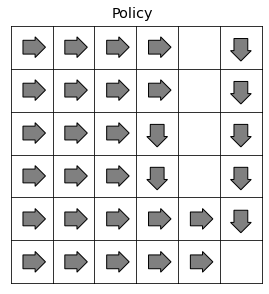

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['font.size'] = 12

class Gridworld:
  def __init__(self, size=6, traps=[], alpha=0):
    self.size = size
    self.traps = traps
    self.alpha = alpha
    self.start = (0, 0)
    self.goal = (size-1, size-1)

    self.states = [(x, y) for x in range(size) for y in range(size)]
    self.actions = [(-1, 0), (0, -1), (1, 0), (0, 1)]
    
    self.policy = {}
    for s in self.states:
      self.policy[(s, (-1, 0))] = 0
      self.policy[(s, (0, -1))] = 0
      self.policy[(s, (1, 0))] = 1/2
      self.policy[(s, (0, 1))] = 1/2

    self.value = {}
    for s in self.states:
      self.value[s] = 0
   
  def move(self, s, a):
    if s == self.goal:
      return [(1, 0, s)]      # Probability, Reward, Next state

    s_new = (s[0] + a[0], s[1] + a[1])

    if s_new not in self.states:
      # Give a penalty to a non-moving action.
      return [(1, -1, s)]     # Probability, Reward, Next state

    if s_new in self.traps:
      # Probability, Reward, Next state
      return [(self.alpha, -1, self.start), (1-self.alpha, -1, self.goal)]

    return [(1, -1, s_new)]   # Probability, Reward, Next state

  def show_values(world, subplot=None, title='Values'):
    if not subplot:
      fig = plt.figure(figsize=(world.size*0.8, world.size*0.8))
      subplot = fig.add_subplot(1, 1, 1)

    result = np.zeros([world.size, world.size])
    for (x, y) in world.states:
      if (x, y) in world.traps:
        result[y][x] = None
      else:
        result[y][x]  = world.value[(x, y)]
    sns.heatmap(result, square=True, cbar=False,
                annot=True, fmt='3.1f', cmap='coolwarm',
                ax=subplot).set_title(title)

def show_policy(world, title='Policy'):
  rotation = {(-1, 0): 180, (0, -1): 90, (1, 0): 0, (0, 1): 270}
  fig = plt.figure(figsize=(world.size*0.75, world.size*0.75))
  fig.subplots_adjust(wspace=0, hspace=0, top=0.92)
  fig.suptitle(title)

  c = 0
  for y in range(world.size):
    for x in range(world.size):
      c += 1
      subplot = fig.add_subplot(world.size, world.size, c)
      subplot.set_xticks([])
      subplot.set_yticks([])
      if (x, y) in world.traps or (x, y) == world.goal:
        direction = None
      else:
        for a in world.actions:
          if world.policy[((x, y), a)] == 1:
            direction = rotation[a]
      if direction != None:
        bbox_props = dict(boxstyle='rarrow', fc='gray')
        subplot.text(0.5, 0.5, '     ', bbox=bbox_props, size=8,
                     ha='center', va='center', rotation=direction)
        
def policy_eval(world, gamma=1, delta=0.01):
  while True:
    delta_max = 0
    for s in world.states:
      v_new = 0
      for a in world.actions:
        results = world.move(s, a)
        for p, r, s_new in results:
          v_new += world.policy[(s, a)] * p * (r + gamma * world.value[s_new])
      delta_max = max(delta_max, abs(world.value[s] - v_new))
      world.value[s] = v_new

    if delta_max < delta:
      break

def policy_update(world, gamma=1):
  update = False
  for s in world.states:
    q_max = -10**10
    a_best = None
    for a in world.actions:
      results = world.move(s, a)
      q = 0
      for p, r, s_new in results:
        q += p * (r + gamma * world.value[s_new])
      if q > q_max:
        q_max = q
        a_best = a

    if world.policy[(s, a_best)] != 1:
      update = True
    for a in world.actions:
      world.policy[(s, a)] = 0
    world.policy[(s, a_best)] = 1
  
  return update

def policy_iteration(world):
  while True:
    print('.', end='')
    policy_eval(world)
    if not policy_update(world):
      print('\n')
      break

world = Gridworld(size=6, traps=[(4, y) for y in range(4)], alpha=0.5)
policy_iteration(world)
show_policy(world)
show_values(world)